In [2]:
function finite_difference_gradient(f, x; h=1e-8)
    n = length(x)
    grad = zeros(n)
    for i in 1:n
        x_forward = copy(x) 
        x_backward = copy(x)
        x_forward[i] += h
        x_backward[i] -= h
        grad[i] = (f(x_forward) - f(x_backward))/2h
    end
    return grad
end

finite_difference_gradient (generic function with 1 method)

In [3]:
using LinearAlgebra

function steepest_optimize(f, x0; step_size=0.1, tol = 1e-6, max_iters = 10000, mode=:max)
    x = copy(x0)
    trajectory = [x]
    for iter in 1:max_iters
        grad = finite_difference_gradient(f,x)
        if norm(grad) < tol
            println("Convergence after $iter iterations")
            break
        end
        if mode == :max
            x += step_size * grad
        elseif mode == :min
            x -= step_size * grad
        else
            error("Invalid mode. choose either :max or :min")
        end
        push!(trajectory, x)
    end
    return x, f(x), trajectory
    
end

steepest_optimize (generic function with 1 method)

In [4]:
f(x) = x[1]^2 + x[2]^2

x0 = [2.0, 2.0]
opt_x_small, opt_f_small, traj_small = steepest_optimize(f, x0; step_size=0.1, mode =:min)
println("Optimal x (step size = 0.1): ", opt_x_small)
println("Minimum value (step size = 0.1): ", opt_f_small)
opt_x_large, opt_f_large, traj_large = steepest_optimize(f, x0; step_size=0.5, mode =:min)
println("Optimal x (step size = 0.5): ", opt_x_large)
println("Minimum value (step size = 0.5)", opt_f_large)

Convergence after 71 iterations
Optimal x (step size = 0.1): [3.2910091337161837e-7, 3.2910091337161837e-7]
Minimum value (step size = 0.1): 2.1661482236406693e-13
Convergence after 2 iterations
Optimal x (step size = 0.5): [1.21549419418443e-8, 1.21549419418443e-8]
Minimum value (step size = 0.5)2.9548522721921134e-16


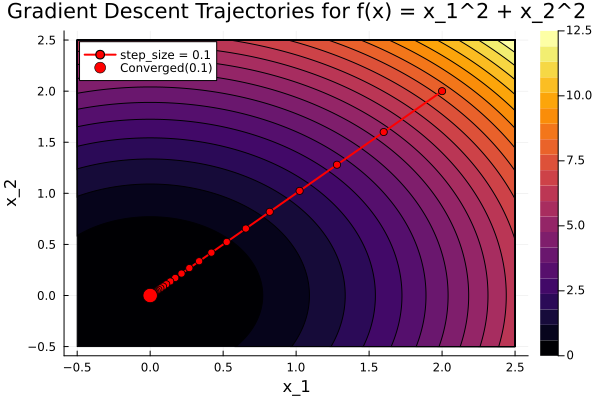

In [5]:
using Plots

xs_small = [p[1] for p in traj_small]
ys_small = [p[2] for p in traj_small]

x_range = -0.5:0.01:2.5
y_range = -0.5:0.01:2.5

z = [f([x, y]) for y in y_range, x in x_range]

contour(x_range, y_range, z, levels = 20, fill = true, title = "Gradient Descent Trajectories for f(x) = x_1^2 + x_2^2", xlabel = "x_1", ylabel = "x_2")
plot!(xs_small, ys_small, marker=:circle, color=:red, lw =2,label="step_size = 0.1")
scatter!([traj_small[end][1]], [traj_small[end][2]], markersize = 8, color=:red, label="Converged(0.1)")

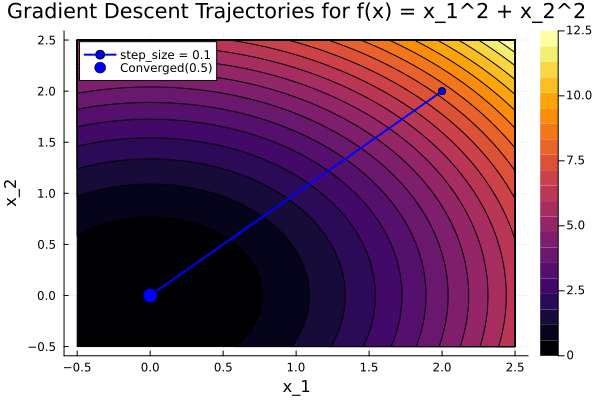

In [6]:
using Plots

xs_large = [p[1] for p in traj_large]
ys_large = [p[2] for p in traj_large]

x_range = -0.5:0.01:2.5
y_range = -0.5:0.01:2.5

z = [f([x, y]) for y in y_range, x in x_range]

contour(x_range, y_range, z, levels = 20, fill = true, title = "Gradient Descent Trajectories for f(x) = x_1^2 + x_2^2", xlabel = "x_1", ylabel = "x_2")
plot!(xs_large, ys_large, marker=:circle, color=:blue, lw =2,label="step_size = 0.1")
scatter!([traj_large[end][1]], [traj_large[end][2]], markersize = 8, color=:blue, label="Converged(0.5)")

In [7]:
import Pkg; Pkg.add("PrettyTables")

   Resolving package versions...
  No Changes to `C:\Users\peakp\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\peakp\.julia\environments\v1.11\Manifest.toml`


In [8]:
using PrettyTables

function simplexBigM(A, b, z, sense; mode=:max)
    m, n = size(A)
    
    for i in 1:m
        if b[i] < 0
            b[i] = -b[i]
            A[i, :] = -A[i, :]
            if sense[i] == "<="
                sense[i] = ">="
            elseif sense[i]  == ">="
                sense[i] = "<="
            end
        end
    end

    slack_count=0
    surplus_count=0
    artificial_count =0
    for s in sense
        if s =="<="
            slack_count+=1
        elseif s == ">="
            surplus_count+=1
            artificial_count+=1
        elseif s =="="
            artificial_count+=1
        else
            error("Unknown constraint type:$s")
        end
    end
    total_vars=n+slack_count+surplus_count+artificial_count

    tableau = zeros(m+1, total_vars+1)
    tableau[1:m, 1:n]= A
    original_labels=["x$i" for i in 1:n]
    extra_labels=String[]
    basis=Int[]
    artificial_indices=Int[]
    surplus_indices=Int[]
    col = n+1
    for i in 1:m
        if sense[i] == "<="
            tableau[i, col] = 1.0
            push!(basis,col)
            push!(extra_labels, "s$i")
            col+=1
        elseif sense[i] == ">="
            tableau[i, col] = -1.0
            push!(surplus_indices, col)
            push!(extra_labels, "s$i")
            col += 1
            tableau[i, col] = 1.0
            push!(basis, col)
            push!(artificial_indices, col)
            push!(extra_labels, "a$i")
            col+=1
        elseif sense[i] == "="
            tableau[i, col] = 1.0
            push!(basis, col)
            push!(artificial_indices, col)
            push!(extra_labels, "a$i")
            col+=1
        end
    end
    var_labels= vcat(original_labels, extra_labels)
    headers=vcat(var_labels, ["RHS"])

    tableau[1:m, end] = b
    M=1e6

    c_vec = mode == :min ? -z : z

    tableau[end, 1:n] = -c_vec
    for j in artificial_indices
        tableau[end, j] = M
    end

    for i in 1:m
        if basis[i] in artificial_indices
            tableau[end, :] -= M * tableau[i, :]
        end
    end

    println("Initial Tableau : ")
    pretty_table(tableau, header=headers)
    println("Initial basis indices : ", basis)
    println("Artificial variable indices : ", artificial_indices)
    println("Surplus variable indices: ", surplus_indices)

    iteration = 0
    while true
        iteration += 1
        println("\n Iteration $iteration: ")
        pretty_table(tableau, header=headers)

        improvement = [-tableau[end, j] for j in 1:total_vars]
        println("Improvement row :", improvement)
        entering_col = argmax(improvement)
        if improvement[entering_col] <= 0
            println("Optimal solution reached. No positive improvement available")
            break
        end
        println("Entering variable : ", headers[entering_col], "(improvement : ", improvement[entering_col], ")")

        ratios = []
        for i in 1:m
            if tableau[i, entering_col] > 1e-10
                push!(ratios, (tableau[i, end] / tableau[i, entering_col], i))
            end
        end
        if isempty(ratios)
            error("the solution is unbounded")
        end
        sorted_ratios = sort(ratios, by = x -> x[1])
        pivot_row = sorted_ratios[1][2]
        pivot_val = tableau[pivot_row, entering_col]
        println("Leaving variable : Row", pivot_row, " (", headers[basis[pivot_row]], " ) with pivot vale :", pivot_val)
        println("Pivoting on element at row ", pivot_row, ", column ", entering_col, " (", headers[entering_col], ")")
        tableau[pivot_row, :] /= pivot_val
        println("After normalizing pivot row")
        pretty_table(tableau[pivot_row:pivot_row, :], header=headers)

        for i in 1:(m+1)
            if i != pivot_row
                factor = tableau[i, entering_col]
                tableau[i, :] -= factor * tableau[pivot_row, :]
                println("Updating row ", i, " (factor: ", factor, " )")
                pretty_table(tableau[i:i, :], header=headers)
            end
        end
        basis[pivot_row] = entering_col
        println("Updated basis indices : ", basis)
        nonbasis_artificial = [j for j in artificial_indices if !(j in basis)]
        if !isempty(nonbasis_artificial)
            println("Removing non-basis artificial variable: ", nonbasis_artificial)
            keep_columns = [j for j in 1:total_vars if !(j in nonbasis_artificial)]
            new_total_vars = length(keep_columns)
            tableau = tableau[:, vcat(keep_columns, [total_vars + 1])]
            var_labels = var_labels[keep_columns]
            headers=vcat(var_labels, ["RHS"])
            basis = [findfirst(isequal(old), keep_columns) for old in basis]
            artificial_indices = [findfirst(isequal(old), keep_columns) for old in artificial_indices if old in keep_columns]
            surplus_indices = [findfirst(isequal(old), keep_columns) for old in surplus_indices if old in keep_columns]
            total_vars = new_total_vars
        end
    end
    solution = zeros(total_vars)
    for i in 1:m
        solution[basis[i]] = tableau[i, end]
    end

    optimum = mode == :min ? -tableau[end, end] : tableau[end, end]
    
    println("\n Final Optimal Tableau")
    pretty_table(tableau, header=headers)
    println("Optimal solution (", join(original_labels, ", "), "): ", solution[1:n])
    println("Optimal objective value: ", optimum)

    return solution[1:n], optimum, tableau, basis
end

simplexBigM (generic function with 1 method)

In [9]:
A = [7.0 11.0; 10.0 8.0; 1.0 0.0; 0.0 1.0]
b = [77.0, 80.0, 9.0, 6.0]
z = [150.0, 175.0]
sense = ["<=", "<=", "<=", "<="]
solution, optimum, final_tableau, basis = simplexBigM(A, b, z, sense; mode=:max)

Initial Tableau : 
┌────────┬────────┬─────┬─────┬─────┬─────┬──────┐
│     x1 │     x2 │  s1 │  s2 │  s3 │  s4 │  RHS │
├────────┼────────┼─────┼─────┼─────┼─────┼──────┤
│    7.0 │   11.0 │ 1.0 │ 0.0 │ 0.0 │ 0.0 │ 77.0 │
│   10.0 │    8.0 │ 0.0 │ 1.0 │ 0.0 │ 0.0 │ 80.0 │
│    1.0 │    0.0 │ 0.0 │ 0.0 │ 1.0 │ 0.0 │  9.0 │
│    0.0 │    1.0 │ 0.0 │ 0.0 │ 0.0 │ 1.0 │  6.0 │
│ -150.0 │ -175.0 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  0.0 │
└────────┴────────┴─────┴─────┴─────┴─────┴──────┘
Initial basis indices : [3, 4, 5, 6]
Artificial variable indices : Int64[]
Surplus variable indices: Int64[]

 Iteration 1: 
┌────────┬────────┬─────┬─────┬─────┬─────┬──────┐
│     x1 │     x2 │  s1 │  s2 │  s3 │  s4 │  RHS │
├────────┼────────┼─────┼─────┼─────┼─────┼──────┤
│    7.0 │   11.0 │ 1.0 │ 0.0 │ 0.0 │ 0.0 │ 77.0 │
│   10.0 │    8.0 │ 0.0 │ 1.0 │ 0.0 │ 0.0 │ 80.0 │
│    1.0 │    0.0 │ 0.0 │ 0.0 │ 1.0 │ 0.0 │  9.0 │
│    0.0 │    1.0 │ 0.0 │ 0.0 │ 0.0 │ 1.0 │  6.0 │
│ -150.0 │ -175.0 │ 0.0 │ 0.0 │ 0.0 │ 0.

([4.888888888888889, 3.888888888888889], 1413.888888888889, [1.0 0.0 … 0.0 4.888888888888889; 0.0 0.0 … 1.0 2.111111111111111; … ; 0.0 1.0 … 0.0 3.888888888888889; 0.0 0.0 … 0.0 1413.888888888889], [1, 6, 5, 2])

You are planning on a healthy diet. On each day, you must get calories at least 2,000 kcal
with at least 50g of protein and at most 70g of fat. You also need to consume vegetable
and fruit at least 2 servings per day. However, you also want to spend least money as
possible per day. Find the minimum cost you can spend to complete your requirements. \
Food Cost (฿/serving) Calories (kcal) Protein (g) Fat (g) \
Chicken 25 250 30 5 \
Rice 5 200 4 1 \
Broccoli 10 50 3 0.5 \
Apple 8 100 0.5 0.2 \
Milk 12 150 8 4 

In [ ]:
# z = 25x_1 + 5x_2 + 10x_3 + 8x_4 + 12x_5
# 250x_1 + 200x_2 + 50x_3 + 100x_4 + 150x_5 >= 2000
# 30x_1 + 4x_2 + 3x_3 + 0.5x_4 + 8x_5  >= 50
# 5x_1 + x_2 + 0.5x_3 + 0.2x_4 + 4x_5 <= 70
# x_3 + x_4 >= 2

A = [
    250.0 200.0 50.0 100.0 150.0;
    30.0 4.0 3.0 0.5 8.0;
    5.0 1.0 0.5 0.2 4.0;
    0.0 0.0 1.0 1.0 0.0;
]
b = [2000.0, 50.0, 70.0, 2.0]
z = [25.0, 5.0, 10.0, 8.0, 12.0]

sense = [">=", ">=", "<=", ">="]
solution, optimum, final_tableau, basis = simplexBigM(A, b, z, sense; mode=:min)

Initial Tableau : 
┌────────┬─────────┬────────┬──────────┬─────────┬───────┬─────┬───────┬─────┬─────┬───────┬─────┬──────────┐
│     x1 │      x2 │     x3 │       x4 │      x5 │    s1 │  a1 │    s2 │  a2 │  s3 │    s4 │  a4 │      RHS │
├────────┼─────────┼────────┼──────────┼─────────┼───────┼─────┼───────┼─────┼─────┼───────┼─────┼──────────┤
│  250.0 │   200.0 │   50.0 │    100.0 │   150.0 │  -1.0 │ 1.0 │   0.0 │ 0.0 │ 0.0 │   0.0 │ 0.0 │   2000.0 │
│   30.0 │     4.0 │    3.0 │      0.5 │     8.0 │   0.0 │ 0.0 │  -1.0 │ 1.0 │ 0.0 │   0.0 │ 0.0 │     50.0 │
│    5.0 │     1.0 │    0.5 │      0.2 │     4.0 │   0.0 │ 0.0 │   0.0 │ 0.0 │ 1.0 │   0.0 │ 0.0 │     70.0 │
│    0.0 │     0.0 │    1.0 │      1.0 │     0.0 │   0.0 │ 0.0 │   0.0 │ 0.0 │ 0.0 │  -1.0 │ 1.0 │      2.0 │
│ -2.8e8 │ -2.04e8 │ -5.4e7 │ -1.015e8 │ -1.58e8 │ 1.0e6 │ 0.0 │ 1.0e6 │ 0.0 │ 0.0 │ 1.0e6 │ 0.0 │ -2.052e9 │
└────────┴─────────┴────────┴──────────┴─────────┴───────┴─────┴───────┴─────┴─────┴───────┴─────┴───

([0.5200000000000001, 8.35, 0.0, 2.0, 0.0], 70.75, [0.0 1.0 … 0.575 8.35; 1.0 0.0 … -0.06 0.5200000000000001; … ; 0.0 0.0 … -1.0 2.0; 0.0 0.0 … 6.625 -70.75], [2, 1, 8, 4])